This notebook contains the analysis and plots for the non-linear system analysis.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from koopmaneigen.koopman_eigensolver import KoopmanEigenSolvers
from koopmaneigen.linearsystemcontinuous import Linear2dSystemContinuous
from koopmaneigen.koopman_eigensolver_dmd import KoopmanEigenSolversDMD
from datafold.pcfold import GaussianKernel, TSCDataFrame


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as ln

from datafold.appfold import EDMD
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis

from koopmaneigen.nonlinearsystem import NonLinear2dSystem

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [3]:
import ipynbname
import os
nb_fname = ipynbname.name()
nb_path = ipynbname.path()
nb_fname

if not os.path.exists(f"plots/{nb_fname}"):
    os.makedirs(f"plots/{nb_fname}")


In [4]:
plt.rcParams['text.usetex'] = True #
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# define system and sample

In [5]:
t_eval = np.linspace(0, 0.4, 21)

initial_conditions = np.array(
    np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 20))
).T.reshape(-1, 2)


In [6]:
def nonlin_ode(t, y):
    """ODE system."""
    y_dot = np.zeros(2)

    y_dot[0] = y[0]
    y_dot[1] = -y[1] +  (y[0] **2)
    return y_dot 

In [7]:
def explict_sol(x1,x2,t):
    return np.array([x1*np.exp(t), (x2 - (x1**2)/3)* np.exp(-t) + (x1**2)/3 * np.exp(2*t)])

In [8]:
# define explicit eigenpairs
eig_i = 1
eig_j = 2
def eigfunction_i(x1, x2):
    return x1

def eigfunction_j(x1, x2):
    return x2

In [9]:
t_sample = 0.4/(t_eval.shape[0]-1)

In [10]:
t_sample.__class__

float

In [11]:
nonlinear_system = NonLinear2dSystem(nonlin_ode, explict_sol, eig_i, eig_j, eigfunction_i, eigfunction_j)

In [12]:
tsc_data = nonlinear_system.sample_system(initial_conditions, t_sample)
print(f"time delta: {tsc_data.delta_time}")
print(f"#time series: {tsc_data.n_timeseries}")
print(f"#time steps per time series: {tsc_data.n_timesteps}")
print(f"(n_samples, n_features): {tsc_data.shape}")
print(f"time interval {tsc_data.time_interval()}")
print(f"Same time values: {tsc_data.is_same_time_values()}")
print("")
print("Data snippet:")
tsc_data

time delta: 0.02
#time series: 400
#time steps per time series: 2
(n_samples, n_features): (800, 2)
time interval (0.0, 0.02)
Same time values: True

Data snippet:


feature         x1        x2
ID  time                    
0   0.00 -2.000000 -2.000000
    0.02 -2.040403 -1.879581
1   0.00 -2.000000 -1.789474
    0.02 -2.040403 -1.673224
2   0.00 -2.000000 -1.578947
...            ...       ...
397 0.02  2.040403  1.628498
398 0.00  2.000000  1.789474
    0.02  2.040403  1.834856
399 0.00  2.000000  2.000000
    0.02  2.040403  2.041213

[800 rows x 2 columns]

In [13]:
# function to add a single arrow in the following time series plots
idx_arrow = np.array([t_eval.shape[0] // 2 - 1, t_eval.shape[0] // 2])


def include_arrow(ax, df, color="black", hw = 0.05):
    ax.arrow(
        df.iloc[-2, 0],
        df.iloc[-2, 1],
        dx=df.iloc[-1, 0] - df.iloc[-2, 0],
        dy=df.iloc[-1, 1] - df.iloc[-2, 1],
        color=color,
        head_width=hw,
    )

In [14]:
dict_step = [
    (
        "polynomial",
        TSCPolynomialFeatures(degree=5),
    )
]

edmd_poly = EDMD(dict_steps=dict_step, include_id_state=True).fit(X=tsc_data)
edmd_poly_values = edmd_poly.predict(tsc_data.initial_states())
len_koopman_matrix = len(edmd_poly.named_steps["dmd"].eigenvectors_right_)
edmd_poly_values_oos = edmd_poly.predict(np.array([0.5, 0.5]), time_values=np.linspace(0, 1, 400))

print(f"shape of Koopman matrix: {len_koopman_matrix} x {len_koopman_matrix}")
edmd_poly.transform(tsc_data).head()

shape of Koopman matrix: 20 x 20


feature        x1        x2      x1^2     x1 x2      x2^2      x1^3   x1^2 x2  \
ID time                                                                         
0  0.00 -2.000000 -2.000000  4.000000  4.000000  4.000000 -8.000000 -8.000000   
   0.02 -2.040403 -1.879581  4.163243  3.835103  3.532826 -8.494692 -7.825154   
1  0.00 -2.000000 -1.789474  4.000000  3.578947  3.202216 -8.000000 -7.157895   
   0.02 -2.040403 -1.673224  4.163243  3.414050  2.799677 -8.494692 -6.966037   
2  0.00 -2.000000 -1.578947  4.000000  3.157895  2.493075 -8.000000 -6.315789   

feature   x1 x2^2      x2^3       x1^4    x1^3 x2  x1^2 x2^2    x1 x2^3  \
ID time                                                                   
0  0.00 -8.000000 -8.000000  16.000000  16.000000  16.000000  16.000000   
   0.02 -7.208387 -6.640232  17.332593  15.966464  14.708012  13.548748   
1  0.00 -6.404432 -5.730281  16.000000  14.315789  12.808864  11.460563   
   0.02 -5.712469 -4.684486  17.332593  14.213520  11.655737   9.558238   
2  0.00 -4.986150 -3.936434  16.000000  12.631579   9.972299   7.872868   

feature       x2^4       x1^5    x1^4 x2  x1^3 x2^2  x1^2 x2^3    x1 x2^4  \
ID time                                                                     
0  0.00  16.000000 -32.000000 -32.000000 -32.000000 -32.000000 -32.000000   
   0.02  12.480856 -35.365469 -32.578016 -30.010266 -27.644902 -25.465973   
1  0.00  10.254188 -32.000000 -28.631579 -25.617729 -22.921126 -20.508375   
   0.02   7.838192 -35.365469 -29.001304 -23.782397 -19.502654 -15.993069   
2  0.00   6.215422 -32.000000 -25.263158 -19.944598 -15.745736 -12.430844   

feature       x2^5  
ID time             
0  0.00 -32.000000  
   0.02 -23.458783  
1  0.00 -18.349599  
   0.02 -13.115049  
2  0.00  -9.813824

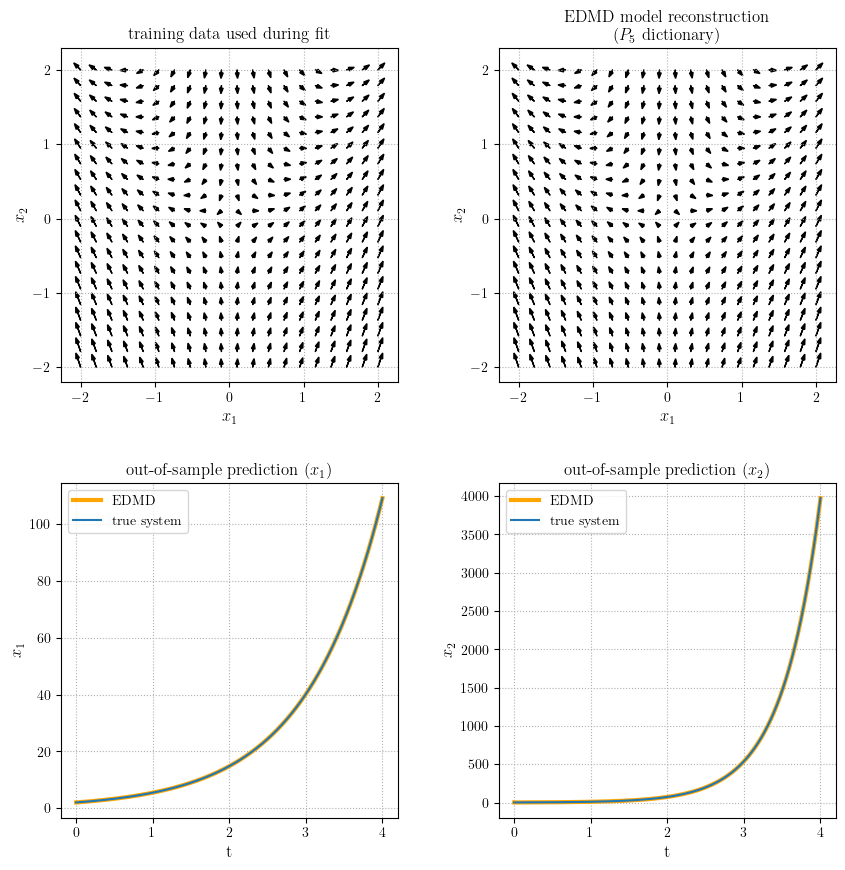

In [15]:
f, ax = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for _id, df in tsc_data.itertimeseries():
    ax[0][0].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black", linewidth=0.5)
    include_arrow(ax[0][0], df)

ax[0][0].set_title("training data used during fit")
ax[0][0].set_xlabel(r"$x_1$", fontsize=12)
ax[0][0].set_ylabel(r"$x_2$",fontsize=12)
ax[0][0].axis("equal")
ax[0][0].grid(linestyle='dotted')

for _id, df in edmd_poly_values.itertimeseries():
    ax[0][1].plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black", linewidth=0.5)
    include_arrow(ax[0][1], df)

# ax[0][1].plot(edmd_poly_values_oos["x1"], edmd_poly_values_oos["x2"], 0.1, c="red")
# include_arrow(ax[0][1], edmd_poly_values_oos, color="red", hw = 0.09)

ax[0][1].set_title("EDMD model reconstruction\n($P_5$ dictionary)")
ax[0][1].set_xlabel(r"$x_1$", fontsize=12)
ax[0][1].set_ylabel(r"$x_2$", fontsize=12)
ax[0][1].axis("equal")
ax[0][1].grid(linestyle='dotted')

# make out-of-sample prediction
initial_condition = np.array([2, 1])
t_eval_new = np.linspace(0, 4, 400)

ground_truth = nonlinear_system.generate_trajectory(initial_condition, t_eval_new)
predicted = edmd_poly.predict(initial_condition, t_eval_new)

ax[1][0].plot(t_eval_new, predicted["x1"], c="orange", label="EDMD", linewidth=3)
ax[1][0].plot(t_eval_new, ground_truth.loc[:, "x1"], label="true system")

ax[1][0].set_title("out-of-sample prediction ($x_1$)")
ax[1][0].set_xlabel("t", fontsize=12)
ax[1][0].set_ylabel(r"$x_1$", fontsize=12)
ax[1][0].grid(linestyle='dotted')
ax[1][0].legend()

ax[1][1].plot(t_eval_new, predicted["x2"], c="orange", label="EDMD", linewidth=3)
ax[1][1].plot(t_eval_new, ground_truth.loc[:, "x2"], label="true system")

ax[1][1].set_title("out-of-sample prediction ($x_2$)")
ax[1][1].set_xlabel("t", fontsize=12)
ax[1][1].set_ylabel(r"$x_2$", fontsize=12)
ax[1][1].grid(linestyle='dotted')
ax[1][1].legend()

plt.savefig(f"plots/{nb_fname}/EDMD_nonlin_explicit_2d.pdf", bbox_inches='tight', dpi=300)
plt.show()

### explicit eigenfunctions

In [16]:
# explict eigenvals
np.exp(1*t_sample), np.exp(2*t_sample)

(1.0202013400267558, 1.0408107741923882)

In [17]:
koopman_eigen_edmd = KoopmanEigenSolvers(edmd_poly, tsc_data, include_id_state=True)
print("shape of koopman matrix: ", koopman_eigen_edmd.koopman_matrix.shape)

shape of koopman matrix:  (20, 20)


In [18]:
koopman_eigen_edmd.left_koopman_eigvals

array([1.10517092+0.j        , 1.08328707+0.j        ,
       1.06183655+0.j        , 1.05441977+0.j        ,
       1.04081077+0.j        , 1.04081077+0.j        ,
       1.02020134+0.j        , 1.02020134+0.j        ,
       1.02020134+0.j        , 1.01588279+0.j        ,
       1.        +0.j        , 0.98019867+0.j        ,
       0.98019867+0.j        , 0.96078944+0.j        ,
       0.96078944+0.j        , 0.94709739+0.02434375j,
       0.94709739-0.02434375j, 0.94176453+0.j        ,
       0.94176453+0.j        , 0.90483742+0.j        ])

/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/matplotlib/contour.py:1454: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = float(z.max())
/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/matplotlib/contour.py:1455: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = float(z.min())
/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/ma/core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


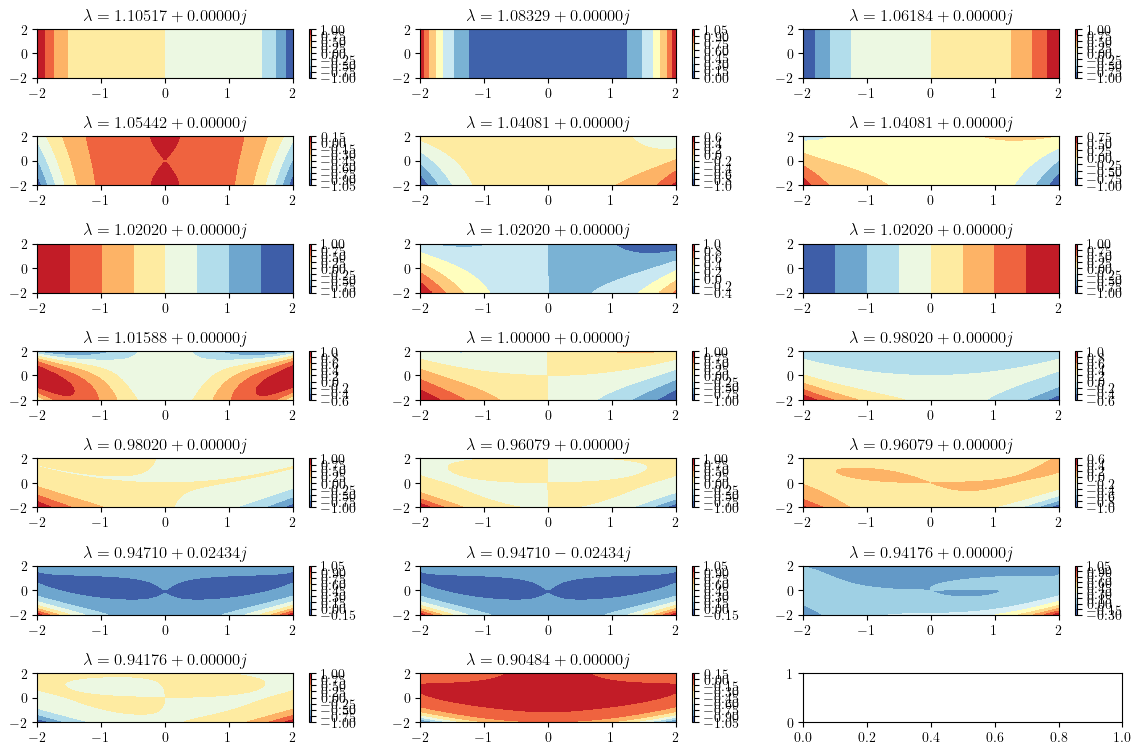

In [19]:
n_plot_dim = int(np.ceil(koopman_eigen_edmd.koopman_matrix.shape[0]/3))
f, ax = plt.subplots(n_plot_dim, 3, figsize=(14, 9))
plt.subplots_adjust(hspace=1.2)

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
x_flat = np.array([X.flatten(), Y.flatten()]).T

koopman_eigenfunctions_eval = koopman_eigen_edmd.eigenfunction_left(koopman_eigen_edmd.left_koopman_eigvecs)(x_flat)

for i in range(koopman_eigenfunctions_eval.shape[1]):
    
    Z = koopman_eigenfunctions_eval[:, i]
    Z = Z/np.max(np.abs(Z))
    
    h = ax[int(i/3)][i%3].contourf(X, Y, np.array(Z).reshape(100,100), cmap='RdYlBu_r')
    eig = koopman_eigen_edmd.left_koopman_eigvals[i]

    ax[int(i/3)][i%3].set_title(f"$\lambda = {eig:.5f}$")
    plt.colorbar(h)    
    
# plt.savefig('plots/EDMD_diffeo_linear_continuous_system_eigenfunctions.png', bbox_inches='tight', dpi=300)
plt.show()

In [20]:
sorted_eig = nonlinear_system.get_sorted_eigvalues(5)

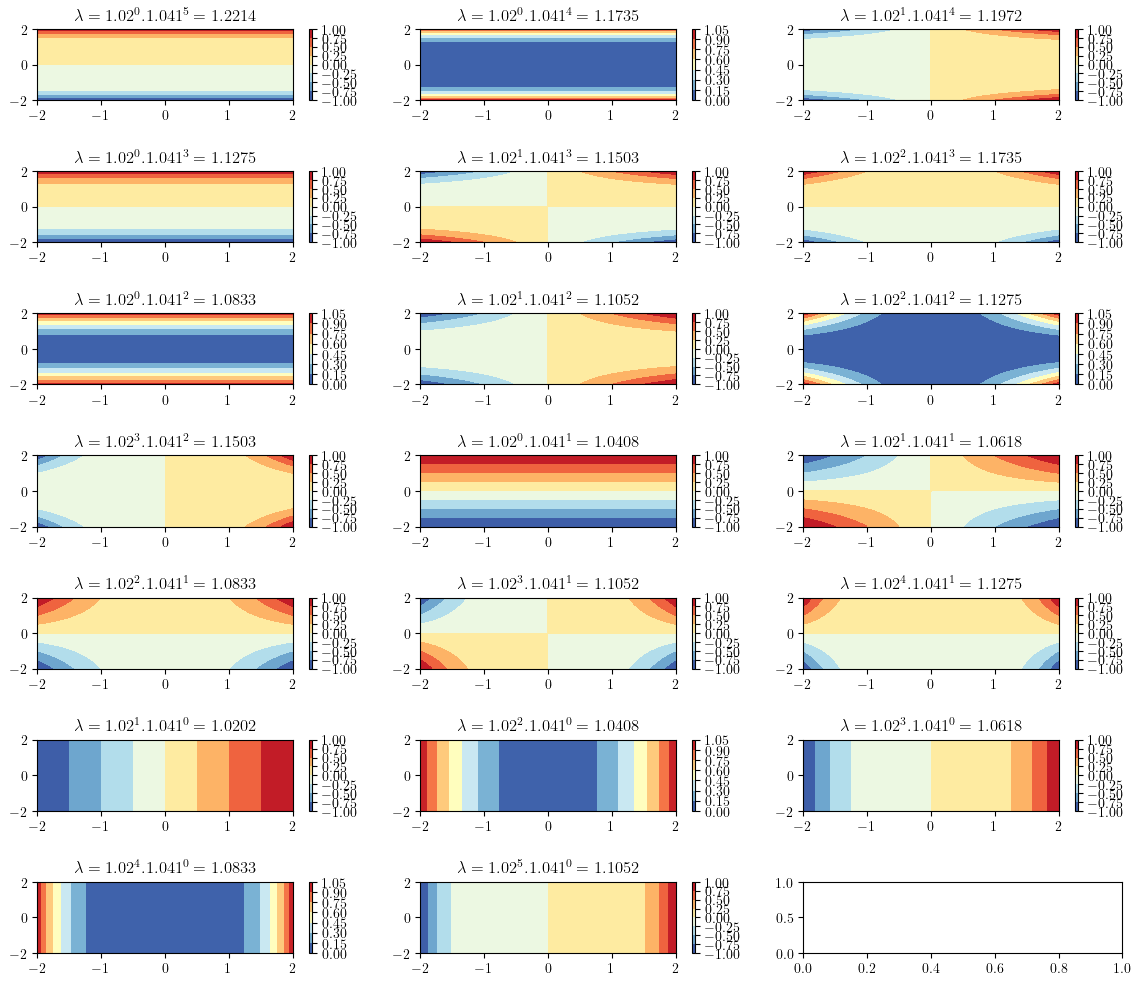

In [21]:
f, ax = plt.subplots(len(sorted_eig)//3 + 1, 3, figsize=(14, 12))
plt.subplots_adjust(hspace=1)

# define grid range
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
x_flat = np.array([X.flatten(), Y.flatten()]).T
    
for i, (m,n) in enumerate(sorted_eig):
    X, Y = np.meshgrid(x, y)
    eigfunc1 = x_flat[:,0]
    eigfunc2 = x_flat[:,1]
    
    Z = (eigfunc1**m) * (eigfunc2**n)
    
    Z = Z.reshape(100,100)
    
#     if normalize:
    Z = Z/np.max(np.abs(Z))

    h = ax[int(i/3)][i%3].contourf(X, Y, Z, cmap='RdYlBu_r')
    
#     linear_system_c.plot_eigenfunction_contour(x=x, y=y, m=m, n=n, ax = ax[int(i/3)][i%3])
    eig = (np.exp(nonlinear_system.eig_i* t_sample))**m * (np.exp(nonlinear_system.eig_j * t_sample)) ** n
    eig_str = f"$\lambda = {np.exp(nonlinear_system.eig_i * t_sample):.4}^{m} . {np.exp(nonlinear_system.eig_j * t_sample):.4}^{n} = {eig:0.4f}$"
    ax[int(i/3)][i%3].set_title(eig_str)
    plt.colorbar(h)

# plt.savefig('plots/EDMD_diffeo_linear_continuous_system_explicit_eigefuncs.png', bbox_inches='tight', dpi=300)
plt.show()

In [22]:
# check if powers of explicit eigenvalues match eigenvalues of EDMD
tol = 1e-7
mn_dict = []
for m in range(0,11):
    for n in range(0,11):
        eig_mn = (np.exp(nonlinear_system.eig_i * t_sample*m) * np.exp(nonlinear_system.eig_j * t_sample*n))
        match = []
        for i, eig in enumerate(koopman_eigen_edmd.left_koopman_eigvals):
            if np.abs(eig.real - eig_mn) < tol:
                match.append(i)
        if len(match)>0:
            mn_dict.append({"m": m, "n": n, "match": match})

In [23]:
mn_dict

[{'m': 0, 'n': 0, 'match': [10]},
 {'m': 0, 'n': 1, 'match': [4, 5]},
 {'m': 0, 'n': 2, 'match': [1]},
 {'m': 1, 'n': 0, 'match': [6, 7, 8]},
 {'m': 1, 'n': 1, 'match': [2]},
 {'m': 1, 'n': 2, 'match': [0]},
 {'m': 2, 'n': 0, 'match': [4, 5]},
 {'m': 2, 'n': 1, 'match': [1]},
 {'m': 3, 'n': 0, 'match': [2]},
 {'m': 3, 'n': 1, 'match': [0]},
 {'m': 4, 'n': 0, 'match': [1]},
 {'m': 5, 'n': 0, 'match': [0]}]

In [24]:
# check if the above combinations also have matching eigenfunctions
for d in mn_dict:
    print(d["m"], d["n"])
    for match in d["match"]:
        print("match: ", match)
        print("rank: ", np.linalg.matrix_rank(np.column_stack((((x_flat[:,0] **d["m"]) * (x_flat[:,1]**d["n"])), koopman_eigenfunctions_eval[:,match]))))
        print(nonlinear_system.c_error(koopman_eigenfunctions_eval[:,match], ((x_flat[:,0] **d["m"]) * (x_flat[:,1]**d["n"]))))
        print("----")
    print("--------------\n")

0 0
match:  10
rank:  2
263573506.9796202
----
--------------

0 1
match:  4
rank:  2
830312791.7661691
----
match:  5
rank:  2
1336165864.2855058
----
--------------

0 2
match:  1
rank:  2
8201186235.98086
----
--------------

1 0
match:  6
rank:  2
1.1593115329742432
----
match:  7
rank:  2
322786298.5883089
----
match:  8
rank:  2
1.159384846687317
----
--------------

1 1
match:  2
rank:  2
1795628774.9750652
----
--------------

1 2
match:  0
rank:  2
29116938269.418156
----
--------------

2 0
match:  4
rank:  2
1087156849.6489568
----
match:  5
rank:  2
2544642966.253318
----
--------------

2 1
match:  1
rank:  2
13947103548.808615
----
--------------

3 0
match:  2
rank:  1
3.814697265625e-06
----
--------------

3 1
match:  0
rank:  2
135628418766.35979
----
--------------

4 0
match:  1
rank:  2
0.001800537109375
----
--------------

5 0
match:  0
rank:  1
0.001708984375
----
--------------



In [25]:
# plot some matches

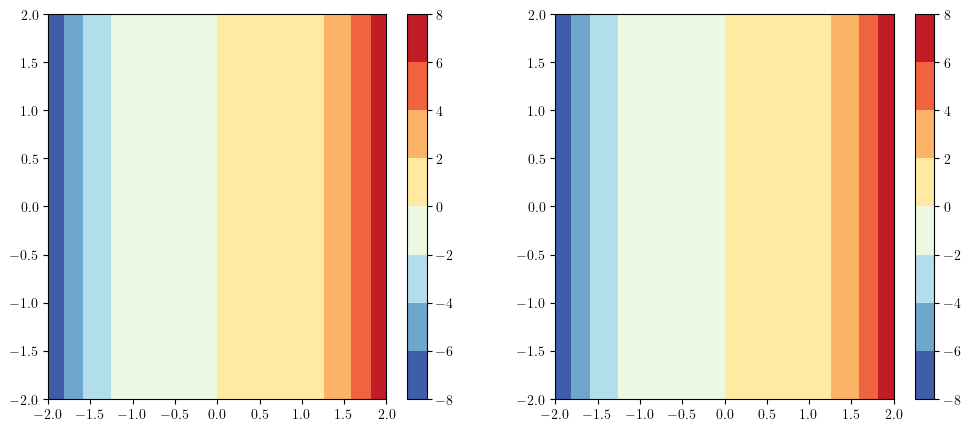

In [26]:
fig,ax = plt.subplots(1,2, figsize=(12,5))

Z = koopman_eigenfunctions_eval[:,2]
Z = Z.reshape(100,100)
# Z = Z/np.max(np.abs(Z))
h = ax[0].contourf(X,Y,Z,cmap='RdYlBu_r')
plt.colorbar(h)

Z =  ((x_flat[:,0] **3) * (x_flat[:,1]**0))
Z = Z.reshape(100,100)
# Z = Z/np.max(np.abs(Z))
h = ax[1].contourf(X,Y,Z,cmap='RdYlBu_r')
plt.colorbar(h)

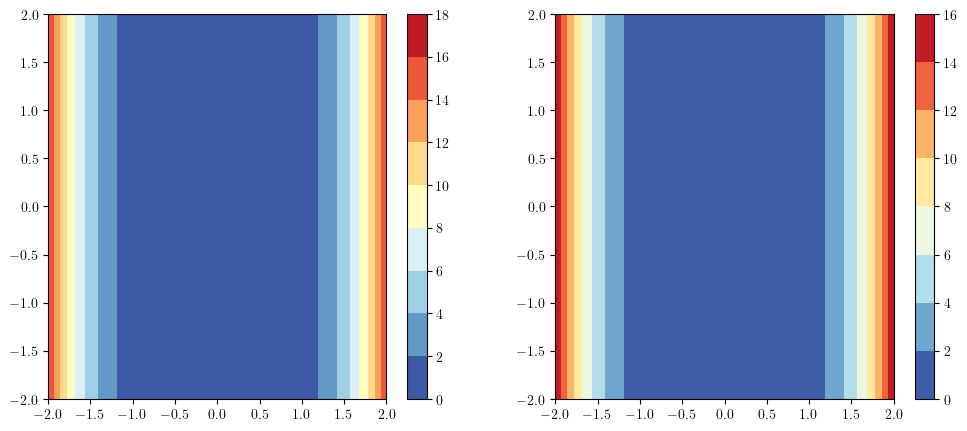

In [27]:
fig,ax = plt.subplots(1,2, figsize=(12,5))

Z = koopman_eigenfunctions_eval[:,1]
Z = Z.reshape(100,100)
# Z = Z/np.max(np.abs(Z))
h = ax[0].contourf(X,Y,Z,cmap='RdYlBu_r')
plt.colorbar(h)

Z =  ((x_flat[:,0] **4) * (x_flat[:,1]**0))
Z = Z.reshape(100,100)
# Z = Z/np.max(np.abs(Z))
h = ax[1].contourf(X,Y,Z,cmap='RdYlBu_r')
plt.colorbar(h)

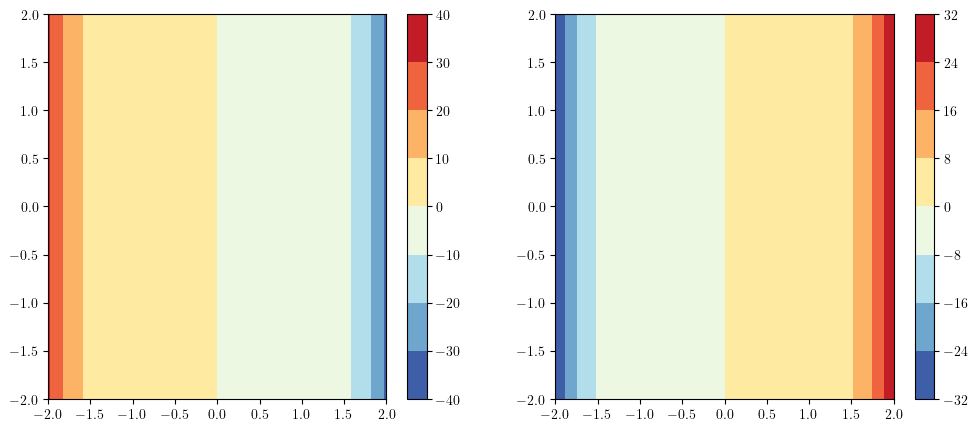

In [28]:
fig,ax = plt.subplots(1,2, figsize=(12,5))

Z = koopman_eigenfunctions_eval[:,0]
Z = Z.reshape(100,100)
# Z = Z/np.max(np.abs(Z))
h = ax[0].contourf(X,Y,Z,cmap='RdYlBu_r')
plt.colorbar(h)

Z =  ((x_flat[:,0] **5) * (x_flat[:,1]**0))
Z = Z.reshape(100,100)
# Z = Z/np.max(np.abs(Z))
h = ax[1].contourf(X,Y,Z,cmap='RdYlBu_r')
plt.colorbar(h)

In [29]:
# check if EDMD eigvals are powers of each other
for i in koopman_eigen_edmd.left_koopman_eigvals:
    for j in koopman_eigen_edmd.left_koopman_eigvals:
        if np.isclose(i, j**2, atol=1e-06):
            print(i,j, 2)
        if np.isclose(i, j**3, atol=1e-06):
            print(i,j,3)
        if np.isclose(i, j**4, atol=1e-06):
            print(i,j,4)
        if np.isclose(i, j**5, atol=1e-06):
            print(i,j,5)
        if np.isclose(i, j**6, atol=1e-06):
            print(i,j,5)
        if np.isclose(i, j**7, atol=1e-06):
            print(i,j,5)

(1.1051709180752236+0j) (1.0202013444418419+0j) 5
(1.1051709180752236+0j) (1.0202013400267431+0j) 5
(1.1051709180752236+0j) (1.0202013356113084+0j) 5
(1.0832870676749489+0j) (1.0408107741929524+0j) 2
(1.0832870676749489+0j) (1.0408107741923303+0j) 2
(1.0832870676749489+0j) (1.0202013444418419+0j) 4
(1.0832870676749489+0j) (1.0202013400267431+0j) 4
(1.0832870676749489+0j) (1.0202013356113084+0j) 4
(1.0618365465451196+0j) (1.0202013444418419+0j) 3
(1.0618365465451196+0j) (1.0202013400267431+0j) 3
(1.0618365465451196+0j) (1.0202013356113084+0j) 3
(1.0408107741929524+0j) (1.0202013444418419+0j) 2
(1.0408107741929524+0j) (1.0202013400267431+0j) 2
(1.0408107741929524+0j) (1.0202013356113084+0j) 2
(1.0408107741923303+0j) (1.0202013444418419+0j) 2
(1.0408107741923303+0j) (1.0202013400267431+0j) 2
(1.0408107741923303+0j) (1.0202013356113084+0j) 2
(1.0000000000000118+0j) (1.0000000000000118+0j) 2
(1.0000000000000118+0j) (1.0000000000000118+0j) 3
(1.0000000000000118+0j) (1.0000000000000118+0j) 4


## run iterative algorithm

In [30]:
from koopmaneigen.matrix_eigsolver import MatrixEigSolver

In [31]:
matrix_eigsolver = MatrixEigSolver(koopman_eigen_edmd.koopman_matrix)

In [32]:
eigs, left_eigs = matrix_eigsolver.power_iteration_with_deflation_asymm_complex(num_eigen=5, 
                                                                                tolerance=1e-13, num_iterations=10000)

eigenvalue 1
iterations:  468
tol achieved in 4 iterations
max iter reached in power method 0.0
tol achieved in 1 iterations
lambda:  (1.1051709180752067+0j)
---------------------------------
eigenvalue 2
max iter reached in power method 0j
tol achieved in 10 iterations
max iter reached in power method 0j
tol achieved in 32 iterations
lambda:  (1.083287067674022+0j)
---------------------------------
eigenvalue 3
max iter reached in power method 0j
tol achieved in 2564 iterations
max iter reached in power method 0j
tol achieved in 83 iterations
lambda:  (1.06183654654507+6.511458039426543e-14j)
---------------------------------
eigenvalue 4
max iter reached in power method 0j
tol achieved in 9 iterations
max iter reached in power method 0j
tol achieved in 152 iterations
lambda:  (1.0544197726219862+2.9392163166484396e-20j)
---------------------------------
eigenvalue 5
max iter reached in power method 0j
max iter reached in above method
max iter reached in power method 0j
tol achieved i

In [33]:
koopman_eigen_edmd.left_koopman_eigvals

array([1.10517092+0.j        , 1.08328707+0.j        ,
       1.06183655+0.j        , 1.05441977+0.j        ,
       1.04081077+0.j        , 1.04081077+0.j        ,
       1.02020134+0.j        , 1.02020134+0.j        ,
       1.02020134+0.j        , 1.01588279+0.j        ,
       1.        +0.j        , 0.98019867+0.j        ,
       0.98019867+0.j        , 0.96078944+0.j        ,
       0.96078944+0.j        , 0.94709739+0.02434375j,
       0.94709739-0.02434375j, 0.94176453+0.j        ,
       0.94176453+0.j        , 0.90483742+0.j        ])

In [34]:
for i, l in enumerate(left_eigs):
    a = l[0]
    a = a.reshape(-1)
    eigvec_edmd = koopman_eigen_edmd.left_koopman_eigvecs[:,i]
    print(np.linalg.matrix_rank(np.array([a, eigvec_edmd])), np.linalg.norm(a+eigvec_edmd), np.linalg.norm(a-eigvec_edmd))

2 8.747074898371765e-10 2.0
2 2.0 2.773960024027415e-10
2 4.387603264842409e-06 1.9999999999951872
2 2.0000000000000004 1.3091452280306998e-11
2 0.2988802386761372 1.9775415552976112


In [35]:
# 5th eigenvec is not matching well

koopman_eigen_edmd.left_koopman_eigvecs[:,1] + left_eigs[1][0]

In [36]:
[e[1] for e in left_eigs]

[(1.105170918075252+0j),
 (1.0832870676780484+0j),
 (1.0618365465449624+0j),
 (1.0544197726225004+2.944999825762607e-20j),
 (1.0408107741928714-1.8256134612986744e-25j)]

In [37]:
np.linalg.norm(koopman_eigen_edmd.koopman_matrix.T@left_eigs[0][0] - eigs[0][1]*left_eigs[0][0])

2.398241033795302e-11

In [38]:
min_eig_eq_norm = np.inf
for i in range(10):
    a, b = matrix_eigsolver.power_iteration_complex_eigs(koopman_eigen_edmd.koopman_matrix.T, 
                                              tolerance=1e-13, max_iterations=10000000)
    eig_eq_norm = np.linalg.norm(koopman_eigen_edmd.koopman_matrix.T@a - b*a)
    if eig_eq_norm < min_eig_eq_norm:
        min_eig_eq_norm = eig_eq_norm
        min_a = a
        min_b = b

max iter reached in power method 0.0
tol achieved in 1 iterations
max iter reached in power method 0.0
tol achieved in 1 iterations
max iter reached in power method 0.0
tol achieved in 1 iterations
max iter reached in power method 0.0
tol achieved in 1 iterations
max iter reached in power method 0.0
tol achieved in 1 iterations
max iter reached in power method 0.0
tol achieved in 1 iterations
max iter reached in power method 0.0
tol achieved in 1 iterations
max iter reached in power method 0.0
tol achieved in 1 iterations
max iter reached in power method 0.0
tol achieved in 1 iterations
max iter reached in power method 0.0
tol achieved in 1 iterations


In [39]:
a, b = matrix_eigsolver.power_iteration_complex_eigs(koopman_eigen_edmd.koopman_matrix.T, 
                                              tolerance=1e-13, max_iterations=10000000)
np.linalg.matrix_rank(np.array([a, eigvec_edmd])), np.linalg.norm(a+eigvec_edmd), np.linalg.norm(a-eigvec_edmd)

max iter reached in power method 0.0
tol achieved in 1 iterations


(2, 1.4975905852511566, 1.3256026700965482)

In [40]:
min_eig_eq_norm, min_a, min_b

(2.0403131728337105e-11,
 array([-2.51312066e-11+0.j,  6.20736962e-13+0.j, -1.64929222e-10+0.j,
         1.22839919e-12+0.j,  4.82138427e-12+0.j,  1.69014107e-10+0.j,
         4.69393172e-12+0.j,  1.22147240e-12+0.j, -3.19971503e-13+0.j,
        -7.32093469e-10+0.j, -5.68690922e-13+0.j, -2.67020760e-12+0.j,
        -2.00790976e-14+0.j, -5.55763358e-13+0.j,  1.00000000e+00+0.j,
         1.42758706e-11+0.j, -6.39071012e-13+0.j, -4.58038634e-13+0.j,
        -1.59410137e-14+0.j,  4.08548316e-14+0.j]),
 (1.1051709180752418+0j))

In [41]:
np.linalg.matrix_rank(np.array([min_a, eigvec_edmd])), np.linalg.norm(min_a+eigvec_edmd), np.linalg.norm(min_a-eigvec_edmd)

(2, 1.4975905852503386, 1.3256026700974723)

a, b = matrix_eigsolver.power_iteration(koopman_eigen_edmd.koopman_matrix.T, 
                                              tolerance=1e-13, max_iterations=10000000)

In [42]:
np.linalg.norm(a), b

(1.0, (1.1051709180752385+0j))

In [43]:
eigs[0][0].reshape(-1)

array([-3.38351802e-14+0.j, -2.28665362e-13+0.j, -6.29623995e-13+0.j,
        1.22344114e-13+0.j, -5.86094870e-12+0.j,  5.23008920e-13+0.j,
       -1.73523265e-11+0.j,  6.60076823e-02+0.j, -2.83930755e-11+0.j,
       -5.14125172e-11+0.j,  1.98023047e-01+0.j, -7.70263938e-11+0.j,
        2.12118432e-01+0.j, -6.90537309e-11+0.j,  5.94069141e-01+0.j,
       -1.85768192e-10+0.j,  4.95155838e-01+0.j, -1.61883916e-10+0.j,
        5.59766184e-01+0.j, -1.59540656e-10+0.j])

In [44]:
eigvec_edmd  = np.linalg.eig(koopman_eigen_edmd.koopman_matrix.T)[1][:,np.linalg.eig(koopman_eigen_edmd.koopman_matrix.T)[0].argmax()]
eig_edmd = np.linalg.eig(koopman_eigen_edmd.koopman_matrix.T)[0].max()

In [45]:
eig_edmd, eigs[0][1]

((1.1051709180752236+0j), (1.1051709180752067+0j))

In [46]:
eigvec_edmd, eigs[0][0]

(array([ 2.51318597e-11+0.j, -6.33782830e-13+0.j,  4.69570470e-12+0.j,
        -1.22945357e-12+0.j, -1.11996109e-12+0.j, -4.75994006e-11+0.j,
        -2.85339747e-13+0.j, -1.22165713e-12+0.j,  3.19340364e-13+0.j,
        -3.38171240e-12+0.j,  1.31145659e-12+0.j,  1.51160182e-13+0.j,
         2.05880064e-14+0.j,  1.78732828e-13+0.j, -1.00000000e+00+0.j,
         1.18055857e-13+0.j,  6.39301622e-13+0.j,  7.18567376e-14+0.j,
         1.58950733e-14+0.j, -4.08485427e-14+0.j]),
 array([[-3.38351802e-14+0.j],
        [-2.28665362e-13+0.j],
        [-6.29623995e-13+0.j],
        [ 1.22344114e-13+0.j],
        [-5.86094870e-12+0.j],
        [ 5.23008920e-13+0.j],
        [-1.73523265e-11+0.j],
        [ 6.60076823e-02+0.j],
        [-2.83930755e-11+0.j],
        [-5.14125172e-11+0.j],
        [ 1.98023047e-01+0.j],
        [-7.70263938e-11+0.j],
        [ 2.12118432e-01+0.j],
        [-6.90537309e-11+0.j],
        [ 5.94069141e-01+0.j],
        [-1.85768192e-10+0.j],
        [ 4.95155838e-01+0

In [47]:
np.linalg.norm(left_eigs[0][0].reshape(-1) - np.linalg.eig(koopman_eigen_edmd.koopman_matrix.T)[1][:,0])

2.0

### calculating errors with upper bound

In [48]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

x_flat = np.array([X.flatten(), Y.flatten()]).T
print(x_flat.shape)

(10000, 2)


In [49]:
t_eval = np.linspace(0,0.4,21)
t_sample = t_eval[-1]/(t_eval.shape[0]-1)
t_sample

0.02

In [50]:
epsilon_G = nonlinear_system.get_euler_eps_G(x_flat, t_eval, integration_method="RK23")
epsilon_G

3.688495770356046e-07

#### calculating L for general polynomial basis

In [51]:
print(edmd_poly.named_steps["polynomial"])

TSCPolynomialFeatures(degree=5)


In [52]:
J = koopman_eigen_edmd.calculate_jacobian_handle()

In [53]:
np.apply_along_axis(lambda _: koopman_eigen_edmd.compute_singular_max(J, _), 1, x_flat).max()

(11.832159566199232+0j)

In [54]:
eigvec = left_eigs[0][0]

eig = left_eigs[0][1]
eig, eigvec.shape

((1.105170918075252+0j), (20, 1))

In [55]:
from scipy.integrate import solve_ivp

eigfunc = koopman_eigen_edmd.eigenfunction_left(eigvec)
Tx = np.apply_along_axis(lambda ic: solve_ivp(nonlin_ode, t_span=(t_eval[0],t_eval[-1]), y0=ic, 
                                              t_eval = t_eval, method="RK23")["y"][:,1],1, x_flat)



In [56]:
nonlinear_system.trajectory_error_power_eigvec(x_flat, koopman_eigen_edmd, eigvec, 
                                               eig, p=1, t_eval=t_eval, integration_method="RK23")

1.3325199184958985e-07

In [57]:
np.linalg.norm(eigfunc(Tx)-eig* eigfunc(x_flat))/np.sqrt(x_flat.shape[0])

1.3325199184958985e-07

In [58]:
np.abs(np.apply_along_axis(lambda _: koopman_eigen_edmd.compute_singular_max(J, _), 1, x_flat)).max() * epsilon_G

4.364287051410369e-06

In [59]:
epsilon_G

3.688495770356046e-07

In [60]:
eigs_algo = [e[1] for e in left_eigs]
eigs_algo

[(1.105170918075252+0j),
 (1.0832870676780484+0j),
 (1.0618365465449624+0j),
 (1.0544197726225004+2.944999825762607e-20j),
 (1.0408107741928714-1.8256134612986744e-25j)]

In [61]:
# check if eigvalues of algo match with explicit eigenvalues
tol = 1e-7
mn_dict_algo = []
for m in range(0,11):
    for n in range(0,11):
        eig_mn = (np.exp(1 * t_sample*m) * np.exp(2 * t_sample*n))
        match = []
        for i, eig in enumerate(eigs_algo):
            if np.abs(eig.real - eig_mn) < tol:
                match.append(i)
        if len(match)>0:
            mn_dict_algo.append({"m": m, "n": n, "match": match})

In [62]:
mn_dict_algo

[{'m': 0, 'n': 1, 'match': [4]},
 {'m': 0, 'n': 2, 'match': [1]},
 {'m': 1, 'n': 1, 'match': [2]},
 {'m': 1, 'n': 2, 'match': [0]},
 {'m': 2, 'n': 0, 'match': [4]},
 {'m': 2, 'n': 1, 'match': [1]},
 {'m': 3, 'n': 0, 'match': [2]},
 {'m': 3, 'n': 1, 'match': [0]},
 {'m': 4, 'n': 0, 'match': [1]},
 {'m': 5, 'n': 0, 'match': [0]}]

In [63]:
# set bound for trajectory error
epsilon = 0.1

In [64]:
# set cutoff for matching eigenfunctions
c_error_cutoff = 1e3

In [65]:
def check_eigpair_explicit(eig, eigvec, c_error_cutoff, eig_tol = 1e-7):
    is_eigfunc_power = []
    for m in range(0,11):
        for n in range(0,11):
            eig_mn = (np.exp(1 * t_sample*m) * np.exp(2 * t_sample*n))
            if np.abs(np.abs(eig) - eig_mn) < eig_tol:
                eigfunc = koopman_eigen_edmd.eigenfunction_left(eigvec)
                c_error_eigfunc = nonlinear_system.c_error(eigfunc(x_flat)**p, ((x_flat[:,0] **m) * (x_flat[:,1]**n)))
                if c_error_eigfunc < c_error_cutoff:
                    is_eigfunc_power.append({"m":m, "n":n})
                print(f"m: {m}, n: {n}, c_error: {c_error_eigfunc}")
    return is_eigfunc_power

In [66]:
print("trajectory error epsilon: ", epsilon)
is_eigfunc_power_list = []


for e in left_eigs:
    eig = e[1]
    is_eigfunc_power_eig = {"eig": eig, "powers": []}
    eigvec = e[0]
    
    eigfunc = koopman_eigen_edmd.eigenfunction_left(eigvec)
    print("-------------------\n")
    print(eig)
#     print(np.abs(eigfunc(x_flat).max()))
    for p in range(1,11):
        print("p: ", p)
        traj_error = nonlinear_system.trajectory_error_power_eigvec(x_flat, koopman_eigen_edmd, eigvec, 
                                               eig, p=p, t_eval=t_eval, integration_method="RK23")
        
        print("error: ", traj_error)
        print("bound: ", nonlinear_system.trajectory_bound_integration(koopman_eigen_edmd, x_flat, p=p, epsilon_G=epsilon_G, eigvalue=eig))
        sugg_eps_G = nonlinear_system.trajectory_bound_given_epsilon(koopman_eigen_edmd, x_flat, p=p, epsilon=epsilon, eigvalue=eig)
        print("suggested eps_G:", sugg_eps_G, epsilon_G < sugg_eps_G)
        print("eigpair_sim:")
        is_eigfunc_power = check_eigpair_explicit(eig ** p, eigvec, c_error_cutoff=c_error_cutoff)
        if epsilon_G < sugg_eps_G and traj_error < epsilon:
            is_eigfunc_power_eig["powers"].append({"p": p, "eigfunc_powers": is_eigfunc_power})
            
    is_eigfunc_power_list.append(is_eigfunc_power_eig)
    print("--------------\n")
    print("--------------")

trajectory error epsilon:  0.1
-------------------

(1.105170918075252+0j)
p:  1
error:  1.3325199184958985e-07
bound:  (4.364287051750182e-06+0j)
suggested eps_G: (0.008451542547285135+0j) True
eigpair_sim:
m: 1, n: 2, c_error: [[444289.21933215]]
m: 3, n: 1, c_error: [[517381.35837134]]
m: 5, n: 0, c_error: [[9.19681042e-09]]
p:  2
error:  0.0004815876136406653
bound:  (0.006568163734156623+0j)
suggested eps_G: (8.549035116464338e-05+0j) True
eigpair_sim:
m: 0, n: 5, c_error: [[580092.62434822]]
m: 2, n: 4, c_error: [[112266.63980261]]
m: 4, n: 3, c_error: [[105433.76521549]]
m: 6, n: 2, c_error: [[49459.16416214]]
m: 8, n: 1, c_error: [[135214.32098546]]
m: 10, n: 0, c_error: [[4.13274392e-09]]
p:  3
error:  0.006950885366744657
bound:  (0.06838716693175745+0j)
suggested eps_G: (1.1532531150209487e-06+0j) True
eigpair_sim:
m: 1, n: 7, c_error: [[111666.65301032]]
m: 3, n: 6, c_error: [[47316.1459766]]
m: 5, n: 5, c_error: [[43229.54701906]]
m: 7, n: 4, c_error: [[26961.99031714]]
m:

suggested eps_G: (8.960425386510868e-05-2.502088842672293e-24j) True
eigpair_sim:
p:  3
error:  0.19212080976680887
bound:  (0.06627717887834192+1.2340827629011431e-21j)
suggested eps_G: (1.2669406436032292e-06-7.077109667305582e-26j) True
eigpair_sim:
p:  4
error:  0.3239001289159579
bound:  (0.20684254837730032+4.3328402232849196e-21j)
suggested eps_G: (2.015070942447565e-08-1.688430870349669e-27j) False
eigpair_sim:
p:  5
error:  0.44196379656599716
bound:  (0.40420311348222815+9.031526751343053e-21j)
suggested eps_G: (3.4186286004234474e-10-3.8192977337190654e-29j) False
eigpair_sim:
p:  6
error:  0.5429517452738797
bound:  (0.6275062316457349+1.460522756778286e-20j)
suggested eps_G: (6.041438450249643e-12-8.436938982388701e-31j) False
eigpair_sim:
p:  7
error:  0.6284110138218867
bound:  (0.855681159486146+2.0485035046393803e-20j)
suggested eps_G: (1.0974470402774471e-13-1.8407341564939152e-32j) False
eigpair_sim:
p:  8
error:  0.7008698850513091
bound:  (1.076993443460586+2.63204

/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/matplotlib/contour.py:1454: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = float(z.max())
/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/matplotlib/contour.py:1455: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = float(z.min())
/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/ma/core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/matplotlib/contour.py:1454: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = float(z.max())
/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/matplotlib/contour.py:1455: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = float(z.min())
/User

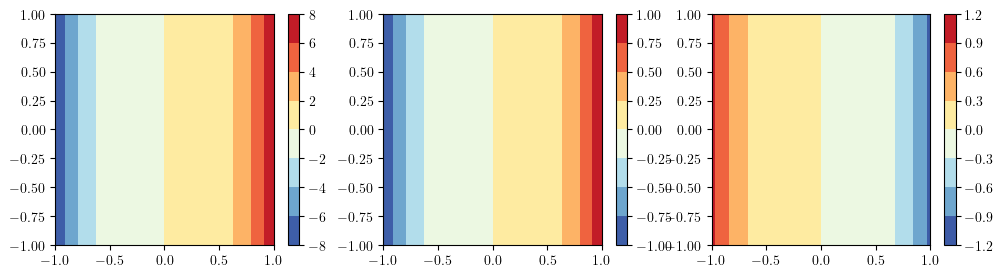

In [67]:
fig,ax = plt.subplots(1,3, figsize=(12,3))

Z = koopman_eigenfunctions_eval[:,2]
Z = Z.reshape(100,100)
# Z = Z/np.max(np.abs(Z))
h = ax[0].contourf(X,Y,Z,cmap='RdYlBu_r')
plt.colorbar(h)

Z =  ((x_flat[:,0] **3) * (x_flat[:,1]**0))
Z = Z.reshape(100,100)
# Z = Z/np.max(np.abs(Z))
h = ax[1].contourf(X,Y,Z,cmap='RdYlBu_r')
plt.colorbar(h)

# eigfunc = koopman_eigen_edmd.eigenfunction_left(eigvec)
Z =  koopman_eigen_edmd.dict_transform(x_flat) @ left_eigs[2][0]
Z = Z.reshape(100,100)
# Z = Z/np.max(np.abs(Z))
h = ax[2].contourf(X,Y,Z,cmap='RdYlBu_r')
plt.colorbar(h)

/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/matplotlib/contour.py:1454: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = float(z.max())
/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/matplotlib/contour.py:1455: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = float(z.min())
/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/numpy/ma/core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


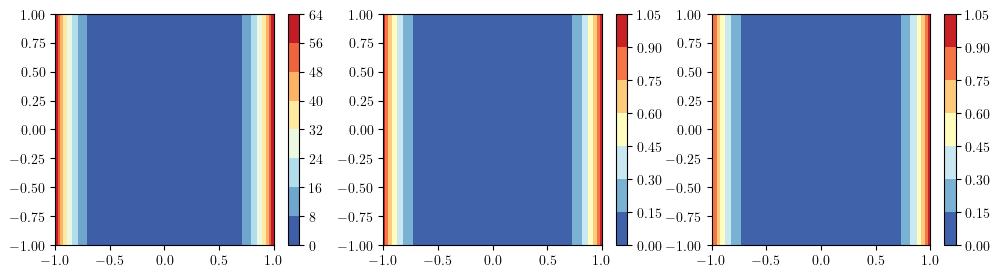

In [68]:
fig,ax = plt.subplots(1,3, figsize=(12,3))

Z = koopman_eigenfunctions_eval[:,2]**2
Z = Z.reshape(100,100)
# Z = Z/np.max(np.abs(Z))
h = ax[0].contourf(X,Y,Z,cmap='RdYlBu_r')
plt.colorbar(h)

Z =  ((x_flat[:,0] **6) * (x_flat[:,1]**0))
Z = Z.reshape(100,100)
# Z = Z/np.max(np.abs(Z))
h = ax[1].contourf(X,Y,Z,cmap='RdYlBu_r')
plt.colorbar(h)

# eigfunc = koopman_eigen_edmd.eigenfunction_left(eigvec)
Z =  (koopman_eigen_edmd.dict_transform(x_flat) @ left_eigs[2][0])**2
Z = Z.reshape(100,100)
# Z = Z/np.max(np.abs(Z))
h = ax[2].contourf(X,Y,Z,cmap='RdYlBu_r')
plt.colorbar(h)

In [69]:
is_eigfunc_power_list

[{'eig': (1.105170918075252+0j),
  'powers': [{'p': 1, 'eigfunc_powers': [{'m': 5, 'n': 0}]},
   {'p': 2, 'eigfunc_powers': [{'m': 10, 'n': 0}]},
   {'p': 3, 'eigfunc_powers': []}]},
 {'eig': (1.0832870676780484+0j),
  'powers': [{'p': 1, 'eigfunc_powers': [{'m': 4, 'n': 0}]},
   {'p': 2, 'eigfunc_powers': [{'m': 8, 'n': 0}]},
   {'p': 3, 'eigfunc_powers': []}]},
 {'eig': (1.0618365465449624+0j),
  'powers': [{'p': 1, 'eigfunc_powers': [{'m': 3, 'n': 0}]},
   {'p': 2, 'eigfunc_powers': [{'m': 6, 'n': 0}]},
   {'p': 3, 'eigfunc_powers': [{'m': 9, 'n': 0}]}]},
 {'eig': (1.0544197726225004+2.944999825762607e-20j),
  'powers': [{'p': 1, 'eigfunc_powers': []}, {'p': 2, 'eigfunc_powers': []}]},
 {'eig': (1.0408107741928714-1.8256134612986744e-25j),
  'powers': [{'p': 1, 'eigfunc_powers': []},
   {'p': 2, 'eigfunc_powers': []},
   {'p': 3, 'eigfunc_powers': []}]}]

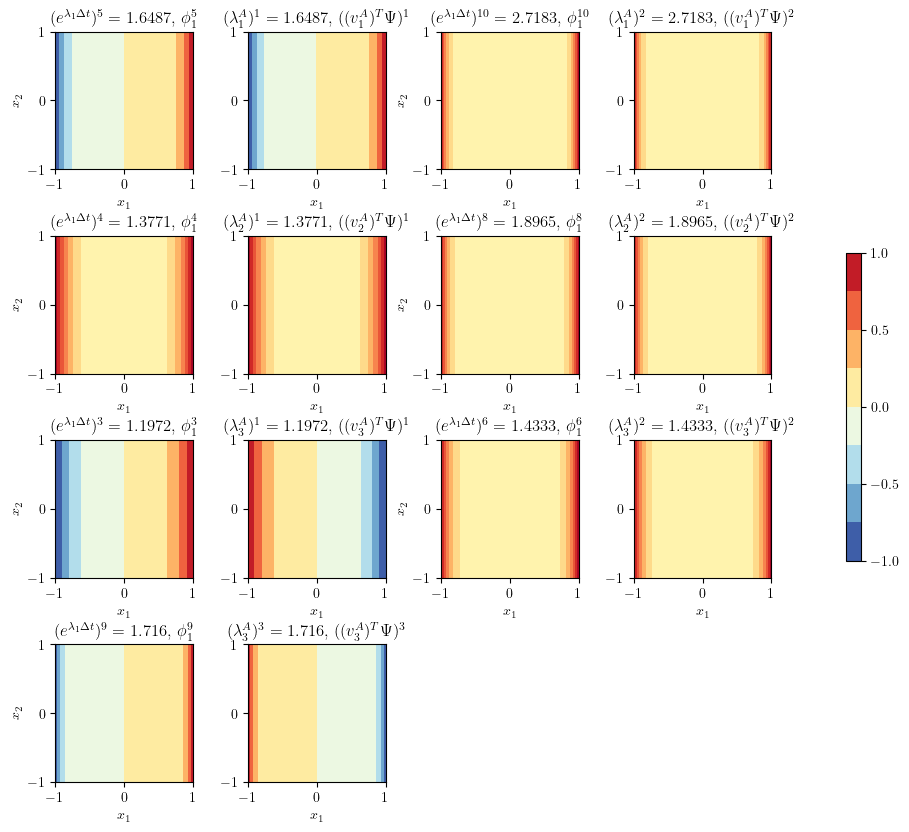

In [73]:
f, ax = plt.subplots(4, 4, figsize=(12,10))
f.delaxes(ax[3,3])
f.delaxes(ax[3,2])

plt.subplots_adjust(hspace=0.3, wspace=0.4)

c = 0
for eig_dict in is_eigfunc_power_list:
    if len(eig_dict["powers"][0]["eigfunc_powers"]) ==0:
        continue

    eig = eig_dict["eig"]
    eig_index = np.where(eigs_algo == eig)[0][0] + 1
    if eig.imag < 1e-8: eig = eig.real

    for eig_dict_power in eig_dict["powers"]:
        
        if len(eig_dict_power["eigfunc_powers"]) == 0:
            continue
            
        row = int(c/2)
        col = (c%2)*2
               
        i = eig_dict_power["eigfunc_powers"][0]["m"]
        j = eig_dict_power["eigfunc_powers"][0]["n"]
        p = eig_dict_power["p"]

        Z =  ((x_flat[:,0] **i) * (x_flat[:,1]**j))
        Z = Z.reshape(100,100)
        Z = Z/np.max(np.abs(Z))
        h = ax[row][col].contourf(X,Y,Z,cmap='RdYlBu_r', vmin=-1, vmax=1)
        ax[row][col].set_xticks([ax[row][col].get_xlim()[0], 0, ax[row][col].get_xlim()[1]])
        ax[row][col].set_yticks([ax[row][col].get_ylim()[0], 0, ax[row][col].get_ylim()[1]])
        ax[row][col].set_xlabel("$x_1$", fontsize=10)
        ax[row][col].set_ylabel("$x_2$", fontsize=10)

        ax[row][col].set_title(f"$(e^" + "{\lambda_1 \Delta t})" + "^{{" + f"{i}" + " }} = " + f"{eig**i:.5}$" + ", $\phi_1^{" + f"{i}" +"}$")
        ax[row][col].set_aspect("equal")

        # eigfunc = koopman_eigen_edmd.eigenfunction_left(eigvec)
        Z =  ((koopman_eigen_edmd.dict_transform(x_flat) @ left_eigs[eig_index-1][0])**p).real
        Z = Z.reshape(100,100)
        Z = Z/np.max(np.abs(Z))
        h = ax[row][col+1].contourf(X,Y,Z,cmap='RdYlBu_r', vmin=-1, vmax=1)
        ax[row][col+1].set_title(f"$(\lambda_{eig_index}^A)^{p} = {eig**i:.5}$" + f", $((v_{eig_index}^A)^T \Psi)^{p}$")
        ax[row][col+1].set_xticks([ax[row][col+1].get_xlim()[0], 0, ax[row][col+1].get_xlim()[1]])
        ax[row][col+1].set_yticks([ax[row][col+1].get_ylim()[0], 0, ax[row][col+1].get_ylim()[1]])
        ax[row][col+1].set_aspect("equal")
        ax[row][col+1].set_xlabel("$x_1$", fontsize=10)
        ax[row][col].set_ylabel("$x_2$", fontsize=10)
        c+=1
        
cbar = f.colorbar(h, ax=ax.ravel().tolist(), shrink=0.4, pad=0.08)
cbar.ax.tick_params(labelsize=10)
cbar.set_ticks(np.arange(-1, 1.1, 0.5))

plt.savefig(f"plots/{nb_fname}/EDMD_nonlin_explicit_match_algorithm.pdf", bbox_inches='tight', dpi=300)
plt.show()